In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

In [2]:
loan = pd.read_csv('loan_df.csv')
pd.set_option('display.max_columns', None)

In [6]:
loan.dtypes

Unnamed: 0                  int64
loan_amnt                 float64
term_is_36m                 int64
int_rate                  float64
installment               float64
emp_length                  int64
annual_inc                float64
is_default                  int64
dti                       float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
list_status_w               int64
mort_acc                  float64
pub_rec_bankruptcies      float64
verification_encoder      float64
application_encoder       float64
home_ownership_encoder    float64
purpose_encoder           float64
grade_encoder             float64
dtype: object

In [82]:
df = loan[['int_rate', 'total_acc', 'revol_util', 'grade_encoder', 'dti', 'emp_length', 'is_default']]

In [83]:
from feyn import QLattice
from feyn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25, random_state=42)

train_X = train.drop('is_default', axis=1)
train_y = train['is_default']


In [84]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42)

X_train_SMOTENC, y_train_SMOTENC = ada.fit_resample(train_X, train_y, 
                                                    )

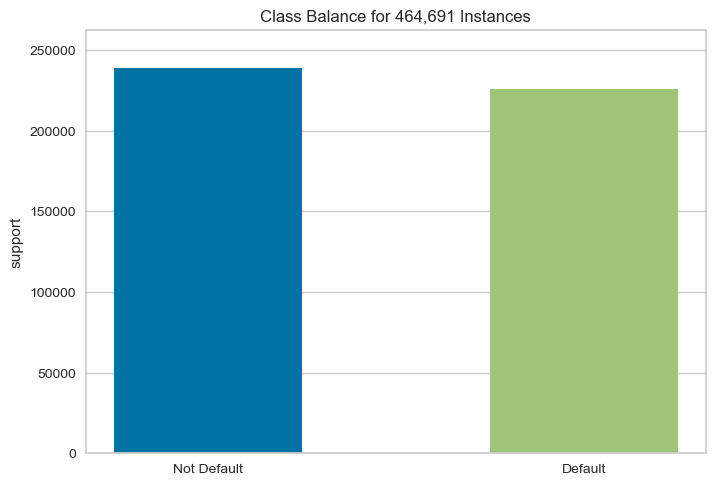

In [87]:
from yellowbrick.target import ClassBalance

def classbalance(y):
    alass = ClassBalance(labels=['Not Default', 'Default'])
    alass.fit(y)
    alass.show()

classbalance(y_train_SMOTENC)

In [88]:
print(train.shape, test.shape)

(297006, 7) (99003, 7)


In [89]:
print(X_train_SMOTENC.shape, y_train_SMOTENC.shape)

(464691, 6) (464691,)


In [16]:
qlattice = QLattice(url='your_qlattice_url', api_token='your_api_token')

In [94]:
train_df = pd.concat([X_train_SMOTENC, y_train_SMOTENC], axis=1)
train_df.head(1)

,int_rate,total_acc,revol_util,grade_encoder,dti,emp_length,is_default
0,14.59,14.0,73.8,0.288678,17.71,2,0


In [96]:
target = 'is_default'
graph = qlattice.get_regressor(train_df, output=target)

In [97]:
graph.best()

[_feyn.Graph (13 interactions),
 _feyn.Graph (3 interactions),
 _feyn.Graph (6 interactions)]

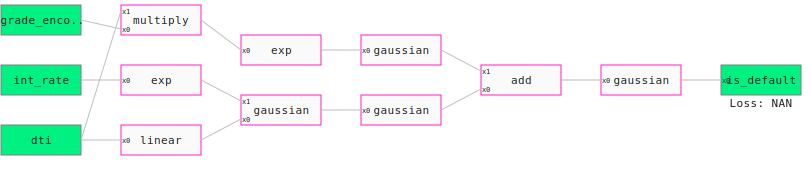

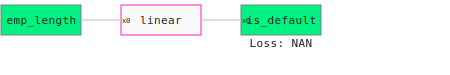

In [98]:
graph.head(2)

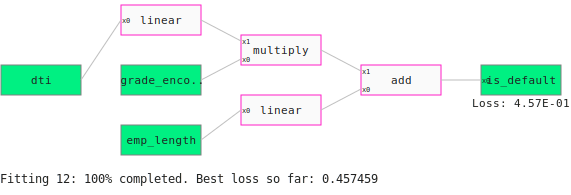

In [101]:
updates = 10

for _ in range(updates):
    graph.fit(train, loss_function='binary_cross_entropy', threads=8)
    best_graphs = graph.best()
    qlattice.update(best_graphs)

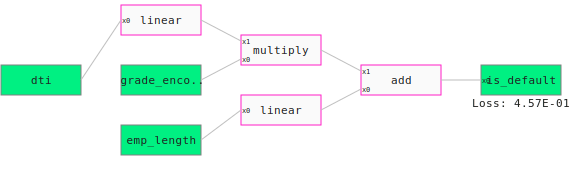

In [102]:
best_graph = best_graphs[0]
best_graph

In [103]:
preds = best_graph.predict(test)
preds = preds.round()

In [104]:
accuracy_score(test['is_default'], preds)

0.8041473490702302

In [105]:
confusion_matrix(test['is_default'], preds)

array([[79103,   484],
       [18906,   510]])

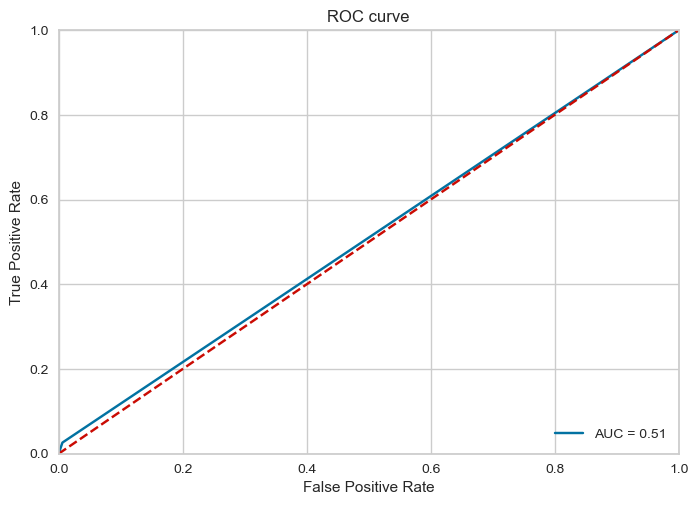

In [106]:
feyn.plots.plot_roc_curve(test['is_default'], preds, title='ROC curve')

In [59]:
from sklearn.metrics import classification_report

In [107]:
print(classification_report(test['is_default'], preds))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     79587
           1       0.51      0.03      0.05     19416

    accuracy                           0.80     99003
   macro avg       0.66      0.51      0.47     99003
weighted avg       0.75      0.80      0.73     99003

